# Spark Project


<center>
Gas Consumption in France
2023-2024
</center>

In [75]:
import pyspark
import yaml
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.conf import SparkConf
from pyspark.sql.functions import year,month,weekofyear
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer,OneHotEncoder, Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from typing import Dict, List, Union



Read some configurations from the yaml file

In [2]:
with open('config.yaml') as f:
    configuration = yaml.safe_load(f)


In [3]:
configuration['service_file_parameters']

[{'delimiter': '|'},
 {'schema': 'id_pdv int,cp int,pop string,latitude double,longitude  double,services string'}]

## 1. Create a Spark Session

In [4]:
conf = SparkConf().setAppName("Gas prediction")\
                  .set("spark.executor.memory", "4g")\
                  .set("spark.driver.memory", "4g")

In [5]:
spark  = pyspark.sql.SparkSession.builder.config(conf=conf).getOrCreate()

24/01/21 10:54:34 WARN Utils: Your hostname, ensai-Precision-3530 resolves to a loopback address: 127.0.1.1; using 192.168.171.30 instead (on interface wlo1)
24/01/21 10:54:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/21 10:54:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark

2. Data preparation

2.1 Read the data from the csv files

Prepare the schema for the different datasets using the yaml configuration file

In [7]:
#get the right delimiter for each each data from the configuration file
gas_delimiter = configuration['gas_file_parameters'][0]['delimiter']
station_delimiter = configuration['station_file_parameters'][0]['delimiter']
service_delimiter = configuration['service_file_parameters'][0]['delimiter']

#get the right schema for each data from the configuration file
gas_schema = configuration['gas_file_parameters'][1]['schema']
station_schema = configuration['station_file_parameters'][1]['schema']
service_schema = configuration['service_file_parameters'][1]['schema']

#collect the file data paths for each data from the configuration file
gas_files = glob.glob("data/Prix*.csv")
station_files = glob.glob("data/Station*.csv")
service_files = glob.glob("data/Service*.csv")



In [8]:
gas_ddf = spark.read.csv(gas_files, schema=gas_schema, sep=gas_delimiter)
station_ddf = spark.read.csv(station_files, schema=station_schema, sep=station_delimiter)
service_ddf = spark.read.csv(service_files, schema=service_schema, sep=service_delimiter)

Explore the gas dataframe

In [9]:
gas_ddf.describe().show()

24/01/21 10:54:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+--------+------------------+-----------------+------------------+-------------+-----------------+
|summary|              id_pdv|                cp|     pop|          latitude|        longitude|      id_carburant|nom_carburant|             prix|
+-------+--------------------+------------------+--------+------------------+-----------------+------------------+-------------+-----------------+
|  count|            21988267|          21988267|21988267|          21987926|         21987931|          21969524|     21969524|         21969524|
|   mean| 5.198771833581928E7|51968.128585122235|    NULL| 4689005.285690996|264577.3844697589| 3.622319445792271|         NULL|789.7721020743362|
| stddev|2.6951331394675057E7|26949.628368838552|    NULL|226446.52624381997|271210.5586687026|2.0553213788233116|         NULL|720.6611761139424|
|    min|             1000001|              1000|       A|  -2094971.3596753|        -472300.0|                 1|    

In [10]:
#number of observations
gas_ddf.count()

21988267

Remove missing observations

In [11]:
c1 = gas_ddf.count()
r = 100 * (c1 -  gas_ddf.dropna(how='any').count() ) / c1
print(f"The removal rate of null observations is {r:.2f}%")


The removal rate of null observations is 0.09%


Save the new data without null observations

In [12]:
gas_ddf = gas_ddf.dropna(how='any')

2.2 Preprocessing the Gas data </br>
We will be doing the following :</br>
* a) Sort date by date column
* b) Split the date in year, month and weak of the year
* c) Prepare latitude & longitude for mapping (divide by the right power of 10)
* d) Fix price columns for certain files who are formatted differently 1000 instead of 1.0
* e) Create a Table associated with gas data

To make it easier we will use a preprocessing pipeline


2.2.a) Convert date column from Timestamp to date and Sort the date by date column 

In [13]:
#change the date format from timestampt to date format
gas_ddf = gas_ddf.withColumn('date',F.date_format("date","yyy-MM-dd"))
#sort 
gas_ddf = gas_ddf.sort("date",ascending = True)

In [14]:
gas_ddf.show(5)

+--------+-----+---+---------------+-------------+----------+------------+-------------+------+
|  id_pdv|   cp|pop|       latitude|    longitude|      date|id_carburant|nom_carburant|  prix|
+--------+-----+---+---------------+-------------+----------+------------+-------------+------+
|86000024|86000|  R|4660415.0216537|33167.5227298|2019-01-01|           1|       Gazole|1342.0|
| 1000013| 1000|  R|  4619851.83794|524350.637881|2019-01-01|           1|       Gazole|1347.0|
|47310006|47310|  A|  4419918.44185|50903.9368657|2019-01-01|           1|       Gazole|1544.0|
| 1100007| 1100|  R|      4624966.0|     564134.0|2019-01-01|           4|         GPLc| 909.0|
|86102001|86100|  R|      4679200.0|      52600.0|2019-01-01|           1|       Gazole|1352.0|
+--------+-----+---+---------------+-------------+----------+------------+-------------+------+
only showing top 5 rows



2.2.b) Split the date in year, month and weak of the year

In [15]:
gas_ddf = gas_ddf.withColumn("year",year(gas_ddf.date))
gas_ddf = gas_ddf.withColumn("month",month(gas_ddf.date))
gas_ddf = gas_ddf.withColumn("weekofyear",weekofyear(gas_ddf.date))
gas_ddf.show(5)

+--------+-----+---+---------------+-------------+----------+------------+-------------+------+----+-----+----------+
|  id_pdv|   cp|pop|       latitude|    longitude|      date|id_carburant|nom_carburant|  prix|year|month|weekofyear|
+--------+-----+---+---------------+-------------+----------+------------+-------------+------+----+-----+----------+
|86000024|86000|  R|4660415.0216537|33167.5227298|2019-01-01|           1|       Gazole|1342.0|2019|    1|         1|
|47310006|47310|  A|  4419918.44185|50903.9368657|2019-01-01|           1|       Gazole|1544.0|2019|    1|         1|
| 1000013| 1000|  R|  4619851.83794|524350.637881|2019-01-01|           1|       Gazole|1347.0|2019|    1|         1|
|47400004|47400|  R|      4440115.0|      29896.0|2019-01-01|           5|          E10|1344.0|2019|    1|         1|
|86102001|86100|  R|      4679200.0|      52600.0|2019-01-01|           1|       Gazole|1352.0|2019|    1|         1|
+--------+-----+---+---------------+-------------+------

2.2.c) Prepare latitude & longitude for mapping (divide by the right power of 10)

In [16]:
gas_ddf = gas_ddf.withColumn("latitude",F.col("latitude")/100_000)
gas_ddf = gas_ddf.withColumn("longitude",F.col("longitude")/100_000)
gas_ddf.show(5)

+--------+-----+---+-----------------+-------------------+----------+------------+-------------+------+----+-----+----------+
|  id_pdv|   cp|pop|         latitude|          longitude|      date|id_carburant|nom_carburant|  prix|year|month|weekofyear|
+--------+-----+---+-----------------+-------------------+----------+------------+-------------+------+----+-----+----------+
|86000024|86000|  R|46.60415021653699|0.33167522729800003|2019-01-01|           1|       Gazole|1342.0|2019|    1|         1|
|47310006|47310|  A|    44.1991844185| 0.5090393686570001|2019-01-01|           1|       Gazole|1544.0|2019|    1|         1|
| 1000013| 1000|  R|    46.1985183794|  5.243506378809999|2019-01-01|           1|       Gazole|1347.0|2019|    1|         1|
|47400004|47400|  R|         44.40115|            0.29896|2019-01-01|           5|          E10|1344.0|2019|    1|         1|
|86102001|86100|  R|           46.792|              0.526|2019-01-01|           1|       Gazole|1352.0|2019|    1|    

2.2.d) Fix price columns for certain files who are formatted differently 1000 instead of 1.0

In [17]:
gas_ddf = gas_ddf.withColumn("prix",F.udf(lambda p,y:p / 1000 if y <= 2021 else p )("prix","year")).sort("year",ascending=True)

2.2.e) Create a Table associated with gas data

In [18]:
gas_ddf.createOrReplaceTempView('gas')
spark.sql("SELECT * FROM gas").show(5)

+--------+-----+---+--------+---------+----------+------------+-------------+-----+----+-----+----------+
|  id_pdv|   cp|pop|latitude|longitude|      date|id_carburant|nom_carburant| prix|year|month|weekofyear|
+--------+-----+---+--------+---------+----------+------------+-------------+-----+----+-----+----------+
|85400005|85400|  R|46.46062| -1.13722|2019-08-24|           2|         SP95|1.433|2019|    8|        34|
| 1000001| 1000|  R|46.20114|  5.19791|2019-01-04|           1|       Gazole|1.328|2019|    1|         1|
|47190001|47190|  R|44.29654|  0.34412|2019-07-22|           1|       Gazole|1.396|2019|    7|        30|
| 1000001| 1000|  R|46.20114|  5.19791|2019-01-07|           1|       Gazole|1.348|2019|    1|         2|
|85400005|85400|  R|46.46062| -1.13722|2019-08-26|           2|         SP95|1.458|2019|    8|        35|
+--------+-----+---+--------+---------+----------+------------+-------------+-----+----+-----+----------+
only showing top 5 rows



Which gas types have some interest for the rest of the project?

In [19]:
spark.sql(
    """
    SELECT nom_carburant,
    count(*) as count,
    round(100 * count(*) / (SELECT count(*) FROM gas),2) as `ratio(%)`
    FROM gas 
    GROUP BY  nom_carburant
    ORDER BY count DESC
    """
    ).show()

+-------------+-------+--------+
|nom_carburant|  count|ratio(%)|
+-------------+-------+--------+
|       Gazole|6671688|   30.37|
|         SP98|5543363|   25.23|
|          E10|5534734|   25.19|
|         SP95|1641710|    7.47|
|          E85|1620438|    7.38|
|         GPLc| 957591|    4.36|
+-------------+-------+--------+



In our dataset, the representation of gas types, specifically **E85 and GPLc**, is notably lower. </br> Their individual ratio stands at approximately 5%, indicating a comparatively lower occurrence in our data.
We will drop those gas types for next part of the project.


In [20]:
gas_ddf.groupby("nom_carburant").agg(F.count("prix")).show()

+-------------+-----------+
|nom_carburant|count(prix)|
+-------------+-----------+
|          E10|    5534734|
|         SP98|    5543363|
|          E85|    1620438|
|       Gazole|    6671688|
|         SP95|    1641710|
|         GPLc|     957591|
+-------------+-----------+



Drop gas types **E85 and GPLc**

In [21]:
gas_ddf = gas_ddf.filter((gas_ddf["nom_carburant"] != "GPLc") & (gas_ddf["nom_carburant"] != "E85"))

In [22]:
gas_ddf.groupby("nom_carburant").agg(F.count("prix")).show()

+-------------+-----------+
|nom_carburant|count(prix)|
+-------------+-----------+
|          E10|    5534734|
|         SP98|    5543363|
|       Gazole|    6671688|
|         SP95|    1641710|
+-------------+-----------+



2.3 Compute price index for each station per week:</br>
Compute a new variable called “Price Index” for each gas type sold in
a station such as:</br>

$𝑷𝒓𝒊𝒄𝒆 𝑰𝒏𝒅𝒆𝒙 = 𝟏𝟎𝟎 × (\frac{𝑫𝒂𝒚 𝑷𝒓𝒊𝒄𝒆 𝒊𝒏 𝒔𝒕𝒂𝒕𝒊𝒐𝒏 − 𝑨𝒗𝒆𝒓𝒂𝒈𝒆 𝑫𝒂𝒚 𝑷𝒓𝒊𝒄𝒆 𝒊𝒏 𝑭𝒓𝒂𝒏𝒄𝒆}{𝑨𝒗𝒆𝒓𝒂𝒈𝒆 𝑫𝒂𝒚 𝑷𝒓𝒊𝒄𝒆 𝒊𝒏 𝑭𝒓𝒂𝒏𝒄𝒆} + 𝟏)$

In [23]:
average_price_gas_ddf = gas_ddf.groupBy(["nom_carburant","date"]).agg(F.avg("prix").alias("avg_day_price"))

gas_ddf = gas_ddf.join(average_price_gas_ddf,on=["nom_carburant","date"],how='inner')

gas_ddf =gas_ddf.withColumn("price_index",
                            100 * 
                            (1 + (F.col("prix") - F.col("avg_day_price")) / F.col("avg_day_price")))

gas_ddf.show(5)


24/01/21 10:59:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+-------+----+---+--------+---------+------------+-----+----+-----+----------+-----------------+-----------------+
|nom_carburant|      date| id_pdv|  cp|pop|latitude|longitude|id_carburant| prix|year|month|weekofyear|    avg_day_price|      price_index|
+-------------+----------+-------+----+---+--------+---------+------------+-----+----+-----+----------+-----------------+-----------------+
|         SP95|2022-06-08|1000001|1000|  R|  46.201|    5.198|           2|2.049|2022|    6|        23|2.141698481561829|95.67173052790191|
|         SP95|2022-06-08|1000001|1000|  R|  46.201|    5.198|           2|2.049|2022|    6|        23|2.141698481561829|95.67173052790191|
|         SP95|2022-06-08|1000004|1000|  R|  46.188|    5.245|           2| 2.12|2022|    6|        23|2.141698481561829| 98.9868563783075|
|         SP95|2022-06-08|1000007|1000|  R|  46.221|    5.245|           2|2.036|2022|    6|        23|2.141698481561829|95.06473565388399|
|         SP95|2022-

2.4 Compute week index:
* Compute a new variable called “Week Index” for each record
counting the number of week since the first week in the file.
* Example: if you loaded years 2019 to 2022, first week of 2019 should be
numbered 1, last week of 2021 should be numbered 156 (3 x 52)

In [24]:

def get_week_index_weights(configuration=configuration) -> Dict[int, int]:
    """
    Generates a dictionary mapping week indexes to corresponding weights based on the configuration.

    Args:
    - configuration (dict): A dictionary containing configuration parameters:
        - 'first_year_gas' (int): The starting year of data collection.
        - 'last_year_gas' (int): The last year of data collection.

    Returns:
    - dict: A dictionary where year indexes are keys, and corresponding weights (multipliers) are values.
    """
    # Get starting year of data collection from the yaml configuration file
    start_year: int = int(configuration["first_year_gas"])

    # Get last year of data collection from the yaml configuration file
    end_year: int = int(configuration["last_year_gas"])

    # Create a list of week indexes from the starting year to the last year
    year_week_indexes: List[int] = list(range(start_year, end_year + 1))

    # Create a list of week indexes multiplier or weights to be associated with corresponding years
    # e.g., if 2015 is the first year, its multiplier will be 0
    year_week_indexes_mulipliers: List[int] = list(range(end_year - start_year + 1))

    # Combine the indexes and the multipliers or weights in a dictionary where the year is the key
    return  dict(zip(year_week_indexes, year_week_indexes_mulipliers))

    


def compute_week_index(weekofyear: int, year: int):
    """
    Computes the week index for a given week of year and year.

    Args:
    - weekofyear (int): The week of the year.
    - year (int): The year.

    Returns:
    - int: The week index.

    e.g
    >>> compute_week_index(1, 2018)
    It returns  1 + 3 * 52 (in this ex 2015 is the starting year)
    """
    # Get the week index multiplier for the given year
    week_index_multiplier =  get_week_index_weights()

    # Compute the week index
    week_index  = weekofyear + week_index_multiplier[year] * 52



    return week_index

In [25]:
gas_ddf = gas_ddf.withColumn("week_index",F.udf(compute_week_index)("weekofyear","year"))

In [26]:
gas_ddf = gas_ddf.sort("date",ascending = True)

3. Data visualization


3.a) Using matplotlib/seaborn or plotly:
* Represent the weekly evolution of average gas price over France such
as:
* Each gas type is a line
* X coordinates is the week index
* Y coordinates is the average price for gas type in France over the
week index

In [27]:
gas_ddf_pandas = gas_ddf.groupby(["nom_carburant","week_index"])\
    .agg(F.avg("prix")\
    .alias("price_per_week_index"))\
    .sort("week_index",ascending = True)\
    .toPandas()

24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 11:00:51 WARN RowBasedKeyValueBatch: Calling spill() on

In [28]:
gas_ddf.show(2)

24/01/21 11:02:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+--------+-----+---+--------+---------+------------+-----+----+-----+----------+-----------------+------------------+----------+
|nom_carburant|      date|  id_pdv|   cp|pop|latitude|longitude|id_carburant| prix|year|month|weekofyear|    avg_day_price|       price_index|week_index|
+-------------+----------+--------+-----+---+--------+---------+------------+-----+----+-----+----------+-----------------+------------------+----------+
|         SP95|2019-01-01|57450001|57450|  R|  49.118|    6.876|           2|1.498|2019|    1|         1|1.493264150943397|100.31714744197207|         1|
|         SP95|2019-01-01| 1000008| 1000|  R|  46.199|    5.241|           2|1.375|2019|    1|         1|1.493264150943397|  92.0801587000745|         1|
+-------------+----------+--------+-----+---+--------+---------+------------+-----+----+-----+----------+-----------------+------------------+----------+
only showing top 2 rows



/tmp/ipykernel_744952/703865181.py:8: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.relplot(


<Figure size 1200x1200 with 0 Axes>

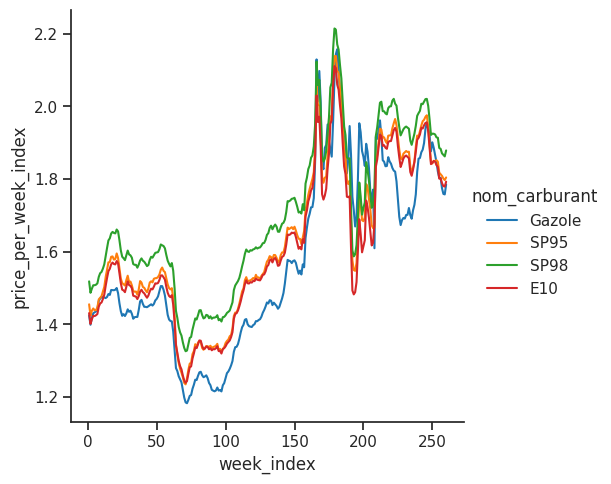

In [29]:
plt.figure(figsize=(12,12))
sns.set_theme(style="ticks")

# Define the palette as a list to specify exact values
palette = sns.color_palette("tab10")
gas_ddf_pandas['week_index'] = gas_ddf_pandas['week_index'].astype(int)
# Plot the lines on two facets
sns.relplot(
    data=gas_ddf_pandas,
    x='week_index', y='price_per_week_index',
hue="nom_carburant",
kind="line",
palette=palette,

facet_kws=dict(sharex=False));

3.b)  Represent a map for each gas type of France geo heat maps of price
indexes, for example at department level

In [30]:
gas_ddf.show()

24/01/21 11:03:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+--------+-----+---+---------------+-------------------+------------+-----+----+-----+----------+------------------+------------------+----------+
|nom_carburant|      date|  id_pdv|   cp|pop|       latitude|          longitude|id_carburant| prix|year|month|weekofyear|     avg_day_price|       price_index|week_index|
+-------------+----------+--------+-----+---+---------------+-------------------+------------+-----+----+-----+----------+------------------+------------------+----------+
|         SP95|2019-01-01|86700004|86700|  R|  46.3356584205|0.18620323995399998|           2|1.492|2019|    1|         1| 1.493264150943397| 99.91534311309903|         1|
|         SP95|2019-01-01| 1000008| 1000|  R|         46.199|              5.241|           2|1.375|2019|    1|         1| 1.493264150943397|  92.0801587000745|         1|
|         SP95|2019-01-01|57450001|57450|  R|         49.118|              6.876|           2|1.498|2019|    1|         1| 1.493264150943397

4. Modeling – Forecast next day price

* Extract day from date
* Create w= 3 lag price features (e.g use upto 3 last days prices to predict next day)
* Select features (day,year,month,weekofyear) 
* Split into train and test

Use the average price per day per gas type data we computed before

In [41]:
average_price_gas_ddf.sort("date",ascending=True).show()

24/01/21 11:35:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+------------------+
|nom_carburant|      date|     avg_day_price|
+-------------+----------+------------------+
|         SP95|2019-01-01| 1.493264150943397|
|          E10|2019-01-01|1.4108494368701878|
|       Gazole|2019-01-01| 1.424227958236655|
|         SP98|2019-01-01|1.5074599348534188|
|          E10|2019-01-02|1.3897919927754412|
|         SP98|2019-01-02|1.4788105906313644|
|       Gazole|2019-01-02| 1.394923447279733|
|         SP95|2019-01-02|1.4157704507512476|
|         SP98|2019-01-03|1.4803267037145362|
|         SP95|2019-01-03| 1.416369769427836|
|       Gazole|2019-01-03|1.3955047326076755|
|          E10|2019-01-03|1.3923583937198074|
|          E10|2019-01-04|  1.38492455418381|
|       Gazole|2019-01-04|1.3865670557145986|
|         SP98|2019-01-04|1.4741281167108704|
|         SP95|2019-01-04|1.4158170019467824|
|          E10|2019-01-05|1.4012511693171237|
|       Gazole|2019-01-05| 1.393294764795146|
|         SP95|2019-01-05|1.412849

In [49]:
test = average_price_gas_ddf.alias("test")

In [50]:
test = test.sort("date",ascending=True)

In [76]:
#day of the month
test = test.withColumn("day",F.dayofmonth("date"))

#year
test = test.withColumn("year",F.year("date"))

#month
test = test.withColumn("month",F.month("date"))

#week of the year
test = test.withColumn("weekofyear",F.weekofyear("date"))

#compute week index
test = test.withColumn("week_index",F.udf(compute_week_index)("weekofyear","year").cast(IntegerType()))


# Create lagged columns for the price
window_spec = Window().partitionBy("nom_carburant").orderBy("date")
window_size = 3

# Create lag features for the last 3 days
lags = []
for i in range(1, window_size + 1):  
    test = test.withColumn(f"lag_avg_price_{i}",F.lag("avg_day_price", i).over(window_spec))

#fill null values created by lagg with 0
test = test.fillna(0)
test.show()

24/01/21 12:36:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+------------------+------------------+------------------+------------------+----+-----+----------+----------+---+
|nom_carburant|      date|     avg_day_price|   lag_avg_price_1|   lag_avg_price_2|   lag_avg_price_3|year|month|weekofyear|week_index|day|
+-------------+----------+------------------+------------------+------------------+------------------+----+-----+----------+----------+---+
|          E10|2019-01-01|1.4108494368701878|               0.0|               0.0|               0.0|2019|    1|         1|         1|  1|
|          E10|2019-01-02|1.3897919927754412|1.4108494368701878|               0.0|               0.0|2019|    1|         1|         1|  2|
|          E10|2019-01-03|1.3923583937198074|1.3897919927754412|1.4108494368701878|               0.0|2019|    1|         1|         1|  3|
|          E10|2019-01-04|  1.38492455418381|1.3923583937198074|1.3897919927754412|1.4108494368701878|2019|    1|         1|         1|  4|
|          E10|2019-

In [77]:

#replace gastype with Gasole, E10 with numeric values 
gas_type_encoding = StringIndexer(inputCol="nom_carburant",outputCol="n_nom_carburant")

#create a vector assembly
#define the feature we're interested in 

features_cols = ["lag_avg_price_1","lag_avg_price_2","lag_avg_price_3",
                 "year","month","week_index","day"]
op_features = VectorAssembler(inputCols=features_cols,outputCol="features")





TRAINING ALGORITHMS

In [78]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor


lr = LinearRegression(labelCol="avg_day_price")

rf = RandomForestRegressor(labelCol="avg_day_price")

pipeline_lr = Pipeline(stages=[gas_type_encoding,op_features,lr])

pipeline_rf = Pipeline(stages=[gas_type_encoding,op_features,rf])

Divide the data into train (0.8) and test(0.2) sets


In [79]:
fitted_lr = pipeline_lr.fit(test)

24/01/21 12:38:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 12:39:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/21 12:39:30 WARN Instrumentation: [b0303316] regParam is zero, which might cause numerical instability and overfitting.
24/01/21 12:39:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/21 12:39:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/01/21 12:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
